# Prediciting particle transport by ocean and wind currents at sea level

Sometime about 500 years ago, famed explorer Ferdinand Magellan said: "The sea is dangerous and its storms terrible, but these obstacles have never been sufficient reason to remain ashore." This quote is mainly about respecting the power of the sea, then with unknown powers. Although the power of the sea never should be underestimated, we are at this day and age able to measure and even predict its power in ocean and wind currents through numerical simulations. These simulations have mulitple usages, and was for example used to caluclate the trajectory of oilspill after the explosion on the oil platform Deepwater Horizon in 2010. In the future these simulations will remain highly relevant due to the oceans increasing amount of plastics. This report will use recorded data of ocean and wind currents to attempt to implement these simulations to predict the trajectory of plastics at sea level along the Norwegian coast.

<hr>

In [3]:
# Import necessary libraries

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time

import xarray as xr
from scipy.interpolate import RectBivariateSpline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**(1a)** For these simulations, it is useful to start off with a simple case without the recorded data. This will be done by simulating a velocity field of wind- and oceanstreams in the $xy$-plane for $x \in \left[0,2\right]$, $y \in \left[0,1\right]$, and then consider particles, $\textbf{r}$, moving in this field. These particles' trajectory will be dependent on the ODE $$ \dot{\textbf{r}} = [v_x(\textbf{r}, t), v_y(\textbf{r}, t)],$$ with $v_x$ and $v_y$ defined as below.

Heun's method, a second-order explicit method, will be implemented to solve this ODE. As seen later, the advantage of this ODE-solver is that with known data at only discreet times, $t_n$, the time interval, $h$, can be adjusted to fit with the timeinterval in the recorded data.

Below are defined necessary constants and functions for solving this ODE. This will be implemented to handle N particles for later use.

In [4]:
#Foreslår flytte konstantene ned, og egt bare slette denne cellen
#Her sto det:

#Define necessary constants

A = 0.1
epsilon = 0.25
omega = 1

In [5]:
#Define necessary constants

A = 0.1
epsilon = 0.25
omega = 1

# Define given functions for simplicty in the ODE
def a(t):
    return epsilon * np.sin(omega * t)

def b(t):
    return 1 - 2 * epsilon * np.sin(omega * t)

def f_a(x, t):
    return a(t) * x**2 + b(t) * x

def fDelX(x, t):
    return 2 * a(t) * x + b(t)

def vX(x, y, t):
    return -np.pi * A * np.sin(np.pi * f_a(x, t)) * np.cos(np.pi * y)

def vY(x, y, t):
    return np.pi * A * np.cos(np.pi * f_a(x, t)) * np.sin(np.pi * y) * fDelX(x, t)

# Final ODE, using the above defined functions
def ODE(coords, t):
    xs = coords[0,:]
    ys = coords[1,:]
    return np.array([vX(xs, ys, t), vY(xs, ys, t)])

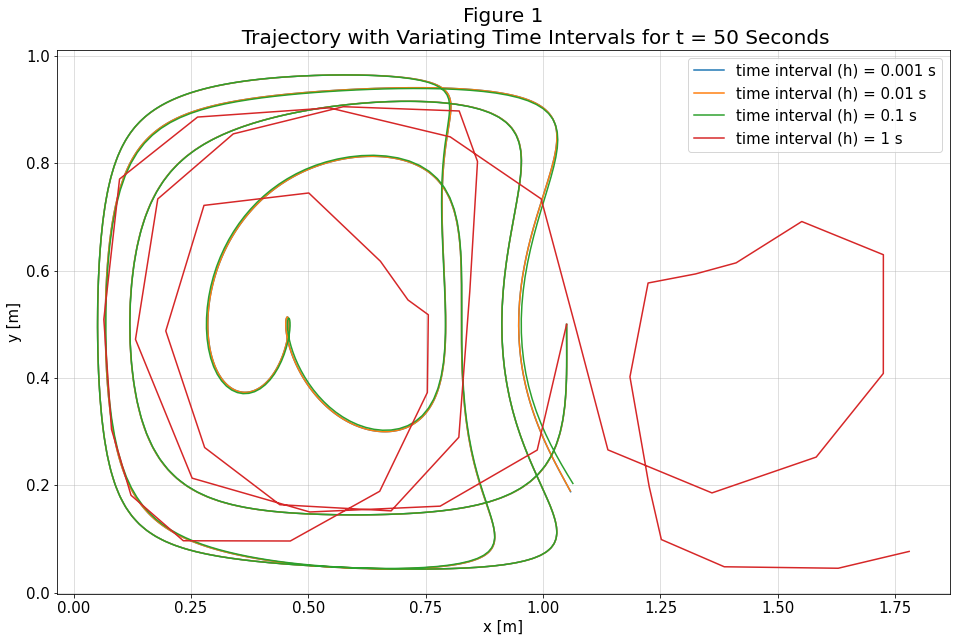

In [6]:
# Implement Heun's method for solving an ODE

def Heun(h, time, initPos, f):
    """Inputs a time interval, amount of time, initial position of the particle, an ODE,
    and returns an array with the coordinates of the particles trajectory"""
    
    t = np.arange(0, time, h)

    #Create an empty array of coordinates, and initialise the first position
    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(t)):
        formerCoord = coordArr[:,:,i-1]
        ti = t[i-1]

        k1 = f(formerCoord, ti)
        tempCoord = formerCoord + k1*h
        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = formerCoord +h/2*(k1 + k2)

    return coordArr

# Plot the trajectory of mulitple particles with variating time intervals
plt.figure(figsize=(16, 10))
plt.title("""Figure 1
          Trajectory with Variating Time Intervals for t = 50 Seconds""", fontsize=20)
plt.xlabel("x [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("y [m]", fontsize=15)
plt.yticks(fontsize=15)

# Initialise startposition
pos0 = np.zeros((2,1))
pos0[0:,] = 1.05
pos0[1:,] = 0.5

hVals = [0.001, 0.01, 0.1, 1]

for h in hVals:
     trajectory = Heun(h, 50, pos0, ODE)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"time interval (h) = {h} s")
     plt.grid(alpha=0.5)
     plt.legend(fontsize=15)

**Figure 1**: Plot of the trajectory of a particle moving for 50 s, using Heuns method in a simulated vectorfield with alternating time intervals.

From **Figure 1** it can be argued that a time interval of about $0.1$ s is a sufficiently short time interval. Generally in stepwise ODE-solvers, the smaller the time interval, the more accurate the simulation is. However, it is also relevant to reduce computing time, and therefore use a larger time intervall, that reduces number of iterations. The trajectories in **Figure 1** for $h = 0.001$ s, $h = 0.01$ s and $h = 0.1$ s all closely overlap, and it is therefore reasonable to use a time interval of 0.1 s going forward.

The accuracy can of course be related to the total amount of time, and it is therefore relevant to investigate if this time interval is just as useful for a total time of 100 s, as done below.

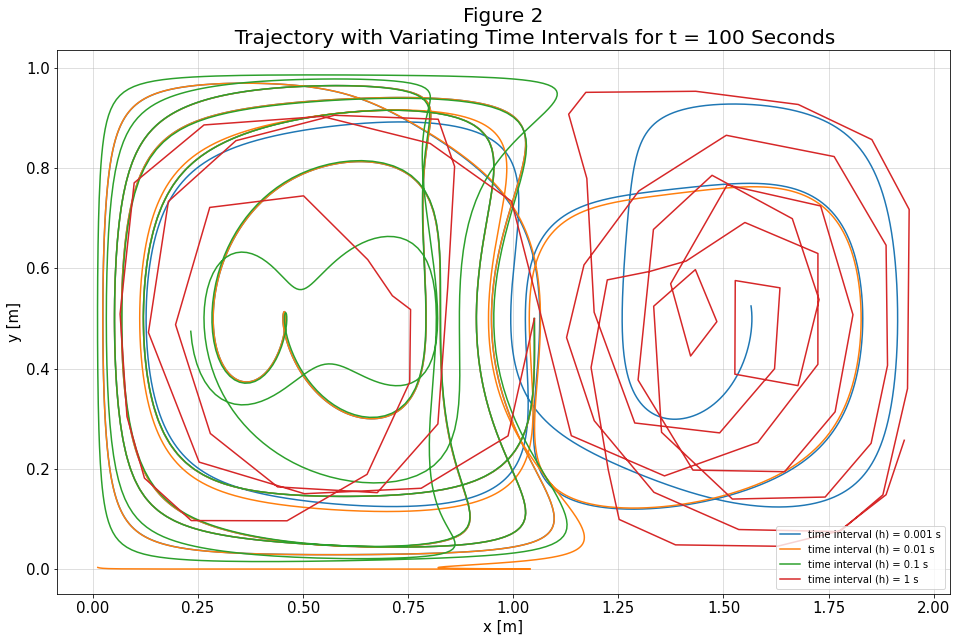

In [7]:
plt.figure(figsize=(16, 10))
plt.title("""Figure 2
          Trajectory with Variating Time Intervals for t = 100 Seconds""", fontsize=20)
plt.xlabel("x [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("y [m]", fontsize=15)
plt.yticks(fontsize=15)

for h in hVals:
     trajectory = Heun(h, 100, pos0, ODE)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"time interval (h) = {h} s")
     plt.grid(alpha=0.5)
     plt.legend()

**Figure 2**: Plot of the trajectory of a particle moving for 100 s, using Heuns method in a simulated vectorfield with alternating time intervals.

From **Figure 2** it can be argued that a time interval of $0.1$ s might not be sufficiently small enough. As argued above, most ODE-solvers are more accurate the smaller the time interval, and in the figure above the simulation with $h = 0.1$ s does not exhibit the same trajectory as the simulations with smaller time intervals. It is therefore reasonable to use a time interval of $h = 0.01$ s going forward.

It can also be noted that the larger time interval $h = 1$ s exhibit similar trajectories to the smaller ones in "exiting" the first circle, but this is likely due to a too big of a time interval, making it's trajectory more random.

**(1b)** It is now natural to observe multiple particles' trajectories in the same plot, given diffrent inital positions. These positions may be totally randomized, but it is interesting to observe how particles close to each other behave differently based on a small distance in initial position. This is done below.

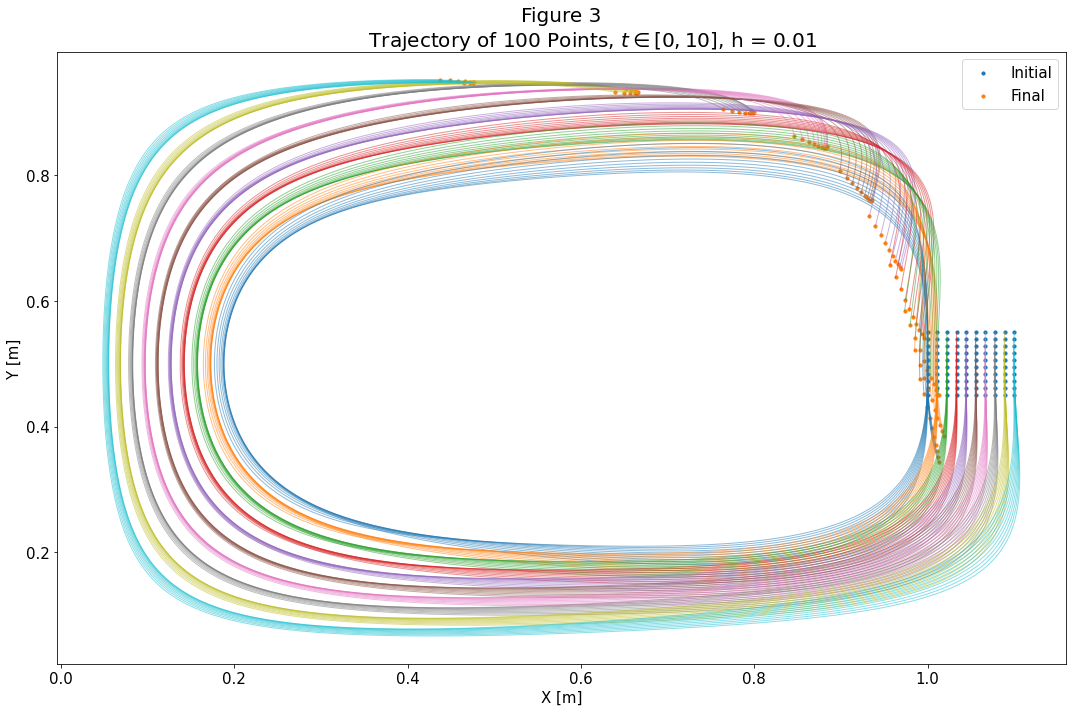

In [8]:
h = 0.01
Np = 100
rows, columns = int(np.sqrt(Np)), int(np.sqrt(Np))

xArr = np.linspace(1, 1.1, rows)
yArr = np.linspace(0.45, 0.55, rows)
X, Y = np.meshgrid(xArr, yArr)
initPositions = np.vstack([X.flatten(), Y.flatten()])

B = Heun(h, 10, initPositions, ODE)

# Plot the trajectories of Np particles in a grid of different initial positions around the inital position from 1a)
plt.figure(figsize=(15,10))
ax= plt.axes()

ax.scatter(initPositions[0,:], initPositions[1,:], s=10, label='Initial')
for i in range(Np):
    ax.plot(B[0,i,:],B[1,i,:], lw=1.0, alpha=0.5)
ax.scatter(B[0,:,-1], B[1,:,-1], s=10, label='Final')

ax.set_xlabel('X [m]', fontsize=15)
ax.set_ylabel('Y [m]', fontsize=15)
ax.legend(fontsize=15)

plt.title("""Figure 3
          Trajectory of 100 Points, $t \in [0,10]$, h = 0.01""", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.tight_layout()

**Figure 3**: Plot of the trajectories of 100 particles moving for 10 s, using Heuns method in a simulated vectorfield.

As in **(1a)**, the particles exhibit traits of moving in a circle, as if caught in an ocean- or windstream. It is however apparent that although particles initially placed close to each other exhibit similar trajectories, as in the figure above, they might end up quite far away from each other. This can be seen by the difference in distance between the innermost (closest to origo) and the outermost particles before and after the simulation, where they go from a distance of $0.1$ m, to about $0.8$ m apart.

**1c)** To ensure that the implementation of `Heun` is sufficiently efficient when presented with larger inputs, it is useful to perform a runtime analysis, where the runtime of the algorithm given values of $N_p$ spanning different orders of magnitude is checked.

In [9]:
# Test implementation by measuring runtime for different numbers of particles, and plot runtime as function of N_p

NpArr = np.logspace(1,5,10, dtype=int)
t = np.zeros(len(NpArr))

for i, N_p in enumerate(NpArr):
    pos0 = np.zeros((2,N_p))
    pos0[0:,] = np.random.rand(N_p)
    pos0[1:,] = np.random.rand(N_p)

    t0 = time()
    trajectory = Heun(0.01, 10, pos0, ODE)
    t1 = time()
    t[i] = t1 - t0

# Plot the runtimes as a function of number of particles
plt.figure(figsize=(7,5))
plt.title("""Figure 4
          Testing Heuns Method on Increasing Numbers of Particles""")
plt.loglog(NpArr, t, label="Heun, $t \in [0,10]$, h = 0.01", color='firebrick')
plt.loglog(NpArr, NpArr/1000, linestyle="--", label="Linear increase", color='black')
plt.xlabel("Number of Particles")
plt.ylabel("Simulation Runtime [s]", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

Looking at the figure above, it seems reasonable that the asymptotic runtime of the implementation is linear. However, when $N_p \in [10^1,10^3]$, the runtime seems to be constant. This is because the implementation has some overhead, which dominate over the work done for each particle for smaller values of $N_p$.

**2a)** The real-life data from the NorKyst800m model is sampled in time intervals of $1$ h and a datapoint for each $800$ m. To account for particles being inbetween these discrete points, interpolation is used to evaluate values for any given position. A class implementing the interpolation is given below. The class also includes a function on_land, which indicates whether a particle has a position that indicates that it has hit land or not. (This code is given on beforehand, and is merely pasted to the two following cells)

In [ ]:
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])

Before plotting on a map, a verification that the dynamic works is preferable. Therefore, a plot directly is performed. The code below calculates the trajectories for all particles, and plots them directly on an xy-grid.

In [ ]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d, fw =0.03)



# Parameters for normal distribution
mean_x = 790000
mean_y = 490000
standard_dev = 10000

Np = 1000

# Create initial positions for the particles
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)


# Run the simulation
E = Heun(3600,3600*5*24,X, f)

In [ ]:
#Plot in the xy-plane

fig = plt.figure(figsize=(9,6))
ax= plt.axes()

ax.scatter(X[0,:], X[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, label='Final')

ax.set_xlabel('X [m]', fontsize=13)
ax.set_ylabel('Y [m]', fontsize=13)
ax.legend(fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

**Figure 5**: A plot of $N_p = 1000$ particles placed somewhere approximately outside Trondheim directly in the xy-coordinates of the NorKyst800m model.

Note the placement of the particles, as these should be recognizable when compared to the same plot on a map. Also note that the x-coordinates are increasing towards north, while y coordinates are increasing towards the west.

2b) It is more interesting to see the positions of the particles on a map. Since map plotting will be essential to the rest of the report, this code is compiled into a function. To facilitate for future needs, the function also returns the data points given by `Heun`, and allows for optional coloring of stranded particles. The function `HeunWithStop` is also implemented below. This function will be used later, but needs to be defined before `plottingFunction` to avoid errors. 

In [ ]:

# Projection data for plotting
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)


def HeunWithStop(h, time, initPos, f):
    t = np.arange(0, time, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(t)):
        formerCoord = coordArr[:,:,i-1]
        ti = t[i-1]
        k1 = f(formerCoord, ti)

        tempCoord = formerCoord + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = np.where(f.on_land(coordArr[:,:,i-1]),formerCoord,formerCoord +h/2*(k1 + k2))

    return coordArr


def plottingFunction(number: int, args: list[tuple], Np: int, h: float, time: float, standard_dev: float, mean_x:float, mean_y:float, ODE:callable =Heun):
    """Function to plot one or more simulations in the same plot.
    Inputs: number: Number of plots
    args: List of tuples containing the extent of the plot, in the form (s, e, b, t)
    Np: Number of particles
    h: Time interval
    time: End time
    standard_dev: Standard deviation of the normal distribution
    mean_x: Mean value of the normal distribution for x
    mean_y: Mean value of the normal distribution for y
    ODE: Function to use for the simulation, default is Heun, other option is HeunWithStop.
    
    Returns: E: np array of shape (number, 2, Np, time//h) with the coordinates of the particles at each time step.
    
    Side effects: Plots the trajectories of the particles in the given plots."""
        
    # Initialize arrays to store the initial positions and the trajectories
    S = np.zeros((number, 2, Np))
    E = np.zeros((number, 2, Np, time//h))

    # Fill start positions with random values from a normal distribution
    for i in range(number):
        S[i, 0, :] = np.random.normal(loc=mean_x[i], scale=standard_dev, size=Np)
        S[i, 1, :] = np.random.normal(loc=mean_y[i], scale=standard_dev, size=Np)

        # Run the simulation for each set of initial positions
        E[i] = ODE(h, time, S[i,:,:], f)

    # Define axes
    fig, axs = plt.subplots(1, number, figsize=(number*6, number*6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

    # If only one plot is to be made, axs is not an array. Set it to an array to avoid issues plotting 1 plot
    if number == 1:
        axs = np.array([axs])
    
    # for each plot, set the extent, add features and plot the trajectories
    for ax, arg, S_j, E_j in zip(axs, args, S, E):
        s, e, b, t = arg
        ax.set_facecolor('#9CC4CF')
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#a5a48b'))
        ax.scatter(S_j[0, :], S_j[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)

        for i in range(Np):
            ax.plot(E_j[0, i,:], E_j[1, i, :], transform=npstere, lw=0.1, alpha=0.3, color='black')
        
        # If the simulation is HeunWithStop, plot the particles that are stranded on land in a different color
        if (ODE==HeunWithStop):
            final_pos = E_j[:, :,-1]
            afloat = final_pos[:,f.on_land(final_pos)==False]
            stranded = final_pos[:,f.on_land(final_pos)==True]

            ax.scatter(afloat[0,:], afloat[1,:], s=1, transform=npstere, label='afloat', color='mediumseagreen')
            ax.scatter(stranded[0,:], stranded[1,:], s=1, transform=npstere, label='on land', color='blueviolet')
        else:
            ax.scatter(E_j[0, :, -1], E_j[1, :, -1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')
        
        ax.set_extent((s, e, b, t))

        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
        ax.legend()

    plt.tight_layout()
    plt.show()
    return E

To visualize how the ocean streams behave along the Norwegian coast, plots of particles placed at four different locations along the coast are created.

In [ ]:
#Extents of the plots
args1 = ((7, 11, 63.5, 65.5), (8, 12, 59.5, 57))
args2 = ((8, 15, 67.5, 70), (25, 30, 70, 72.2))

#Normal distribution params
mean_x1 = np.array([790000, 190000])
mean_x2 = np.array([1220000, 1915000])

mean_y1 = np.array([490000, 110000])
mean_y2 = np.array([620000, 300000])

std = 10000

# Plotting two and two functions for visualization purposes
_ = plottingFunction(len(mean_x1), args1, 1000, 3600, 3600*24*5, std, mean_x1, mean_y1)
_ = plottingFunction(len(mean_x2), args2, 1000, 3600, 3600*24*5, std, mean_x2, mean_y2)

**Figure 6**: Particle movements when placed four different places along the Norwegian coast.

The top left image shows the same example as Figure 5, now projected onto a map. The other locations show selected positions along the Norwegian coast. The results look different for each position, which is logical considering ocean and wind currents are different. (Dette er tynn suppe hilsen petar)

3) Until now, the model has not taken into account that particles might end up hitting land. The function `on_land` from the `Interpolate` class will be used to modify the `Heun` method. The modified implementation, `HeunWithStop`, is given above due to it being necessary to avoid not defined-errors.

In [ ]:
# Definert før, kan fjerne denne. Kan kommentere i teksten over at den er definert før.

def HeunWithStop(h, time, initPos, f):
    t = np.arange(0, time, h)
    # Array to store all coordinates
    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    # Set initial positions
    coordArr[:,:,0] = initPos

    # Performs a Heun step for each time step
    for i in range(1, len(t)):
        formerCoord = coordArr[:,:,i-1]
        ti = t[i-1]
        k1 = f(formerCoord, ti)

        tempCoord = formerCoord + k1*h

        k2 = f(tempCoord, ti + h)

        # If the particle is on land, set the position to the previous position, else, update position.
        coordArr[:,:,i] = np.where(f.on_land(coordArr[:,:,i-1]),formerCoord,formerCoord +h/2*(k1 + k2))

    return coordArr

3a) The modified method provides the opportunity to examine how many particles strand, as well as where and when they strand. To look into this, we place particles around a point off the coast of Western Norway and simulate their movements.

In [ ]:
# Placement parameters
args = [(3, 6, 59.25, 61.5)]

mean_x = np.array([250000])
mean_y = np.array([460000])

# Store values for use in windage analysis. array access to get dimensions right
E = plottingFunction(1, args, 1000, 3600, 3600*24*3, 10000, mean_x, mean_y, HeunWithStop)[0]

In [ ]:
# Slett denne når alle er på main

**Figure 7**: Plot showing the movement of particles over 3 days, taking into account stranding of particles. The green dots indicate stranded particles, while the orange dots indicate particles still afloat.

Observing the particle trajectories, one can see that quite a few have stranded while other particles are very close to the shore. This might suggest that a significant number of particles have stranded recently. To assess this suggestion, a plot of the percentage of stranded particles as a function of time is a good tool. 

In [ ]:

num_stranded = np.zeros(E.shape[-1])
for i in range(E.shape[-1]):
    # Count the number of particles that are on land at each time step
    num_stranded[i] = np.count_nonzero(f.on_land(E[:,:,i]))

plt.plot(num_stranded/E.shape[1]*100)
plt.xlabel('Time [h]')
plt.ylabel('Percentage of stranded particles')

**Figure 8**: Plot showing the number of stranded particles as a function of time. 

We see that, as intuition would suggest, the longer the particles move, the more likely they are to hit land.

3b) Another factor that affects whether or not the particles reach the shore, is the wind and the windage factor of the particle. This is a factor relating the effect of the wind on the particle to the effect of water currents. Simulating particle drifts from the same initial positions while varying $f_w$ gives insight into what happens with increased contribution of the wind.

In [ ]:
# Values for f_w
f_w_arr = np.linspace(0, 0.15, 10)
#Preparing array for storing stranded particles
stranded_arr = np.zeros(f_w_arr.shape)

# Create initial positions for the particles
X = np.zeros((2, 1000))
X[0,:] = np.random.normal(loc=mean_x[0], scale=10000, size=1000)
X[1,:] = np.random.normal(loc=mean_y[0], scale=10000, size=1000)

# Run the simulation for each windage factor
for i, f_w in enumerate(f_w_arr):
    # Need to create an individual interpolator for each windage factor
    g = Interpolator(dataset = d, fw = f_w)
    E = HeunWithStop(3600,3600*3*24,X, g)
    num_stranded = np.count_nonzero(f.on_land(E[:,:,-1]))
    # Store result of simulation
    stranded_arr[i] = num_stranded

# Plot the results (percentage for stranded particles)
plt.plot(f_w_arr, stranded_arr/X.shape[1]*100)
plt.xlabel('Windage factor')
plt.ylabel('Percentage of stranded particles after 3 days')
plt.tight_layout()

Figure n: The function of stranded particles with regards to the windage factor. 

As the windage factor increases, the number of stranded particles increases accordingly, with the largest increase when $f_w \approx 0.03$ Thus, it seems that the wind is pulling the particles towards the shore. To further examine if this is the case, we can plot the direction of the wind as a vector field to see if it pushes the objects towards land.

In this project, a numerical model for analyzing plastics moving in water, namely the Lagrangian particle model, was examined. Initially, a theoretical test case was used to establish the relation between simulation intervals and time steps. A method for plotting the particle trajectories was implemented, and an approximate runtime analyis was performed. Thereafter, real-world wind and waterstream data was used to examine movements along the Norwegian coast. Finally, shore contact was implemented, and analysis of how the wind affected the amount of particles reaching the shore was performed.

Kilde